# Zeitreihenanalyse

In diesem Notebook werden einfache Zeitreihenanalysen und deren deskriptive statistische Modellierung mittels Zeitreihenzerlegung vorgestellt. Als Beispiel soll die Entwicklung der Feinstaubbelastung mit PM2.5 in Hamburg mit der In Atlanta analysiert werden.

Hamburg und Atlanta sind beides wichtige, international ausgerichtete urbane Zentren, in unterschiedlichen Regionen. Hier einige Gemeinsamkeiten:

- **Wirtschaft und Handel**:
Hamburg ist einer der bedeutendsten Hafen- und Logistikstandorte Europas, während Atlanta als bedeutender Verkehrsknotenpunkt und Wirtschaftszentrum im Süden der USA gilt. Beide Städte spielen eine zentrale Rolle im regionalen und internationalen Handel.

- **Urbanität und internationale Ausrichtung**:
Sowohl Hamburg als auch Atlanta sind multikulturelle Metropolen, die als regionale Drehscheiben fungieren und internationale Unternehmen sowie vielfältige Bevölkerungsschichten anziehen.

- **Saisonale Dynamik**:
Beide liegen in der nördlichen Hemisphäre und erleben saisonale Veränderungen, auch wenn ihre Klimatypen unterschiedlich sind (maritimes Klima in Hamburg versus subtropisches Klima in Atlanta). Diese Saisonalität spielt in beiden Fällen eine Rolle bei der Entwicklung der Luftqualität.

Diese Gemeinsamkeiten machen den Vergleich in Bezug auf die Entwicklung der Feinstaubbelastung spannend, da beide Städte trotz unterschiedlicher klimatischer Rahmenbedingungen und regionaler Besonderheiten ähnliche Herausforderungen im urbanen Umfeld haben.

Verwendet werden:
- matplotlib.pyplot für einfache Visualisierungen von Zeitreihen
- statsmodels.tsa.seasonal zum Berechnen langfristiger Trends und saionaler Muster

📌 **Datenstand:** `cleaned_air_quality_data_2025-03-27.csv`  
📁 **Importiert aus:** lokaler Datei (--> gitignore)

Anmerkung: Der aktuelle Datensatz enthält keine Datumsspalte mehr. Diese muss also aus Year, Menth, Day wieder erzeugt werden. Das sollte irgendwann noch korrigiert werden, so dass die Datummspalte beim Data-Celaning erhalten bleibt.

## 📚 Inhaltsverzeichnis 
(Diese Art von Inhaltsverzeichnis mit Link funktioniert leider in Notebooks nicht, weil die as JSON gespeichert werden und nicht als HTML...)

- [0. Datensatz laden](#0-datensatz-laden)
- [1. Dataframes vorbereiten](#1-dateframe-vorbereiten)
- [2. Einfache Zeitreihen](#2-einfache-zeitreihen)
- [3. Zeitreihenzerlegung: Hamburg](#3-zeitreihenzerlegung-hamburg)
- [4. Zeitreihenzerlegung: Atlanta](#zeitreihenzerlegung-atlanta)
- [5. Zusammenfassende Bewertung](#5-zusammenfassende-bewertung)

# 0. Datensatz laden

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,6.0,45.0,18.8,15.8,24.1,NaN,183.0,21.9,1022.3
1,2019,3,1,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,12.0,64.0,17.0,13.5,23.0,NaN,185.0,21.2,1021.9
2,2019,3,2,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,9.0,63.0,16.7,10.8,23.6,NaN,186.0,15.2,1022.3
3,2019,3,3,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,6.0,55.0,15.9,10.8,22.0,NaN,196.0,16.5,1023.4
4,2019,3,4,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,3.0,58.0,16.1,9.0,22.5,NaN,NaN,11.2,1023.8


# 1. Dataframes vorbereiten

Wir wollen sicherstellen, dass wir zwei Städte vergleichen, die für den Zeitraum von 2015 bis 2024 auch tatsächlich durchgängig Messwerte für PM2.5 erhoben haben. Dazu bestimmen wir zuerst alle Städte, die diesem Kriterium entsprechen:

In [3]:
# Sicherstellen, dass PM25-Werte nicht NaN sind
df_valid_pm25 = df[df['Pm25'].notna()]

# Gruppiere nach Stadt und Jahr und zähle die einzigartigen Jahre mit gültigen PM25-Werten
cities_years_with_pm25 = df_valid_pm25.groupby('City')['Year'].nunique()

# Filtere Städte, die in allen Jahren von 2015 bis 2024 (10 Jahre) gültige PM25-Werte haben
valid_cities_with_pm25 = cities_years_with_pm25[cities_years_with_pm25 == 12].index

# Ausgabe der Städte mit gültigen PM25-Werten für alle Jahre von 2015 bis 2024
print("Städte mit gültigen PM25-Werten für alle Jahre 2015 bis 2024:", valid_cities_with_pm25)


Städte mit gültigen PM25-Werten für alle Jahre 2015 bis 2024: Index(['Akita', 'Amsterdam', 'Ankara', 'Antwerpen', 'Anyang', 'Ashdod',
       'Atlanta', 'Austin', 'Baltimore', 'Beijing',
       ...
       'Xinxiang', 'Xi’an', 'Xuchang', 'Yinchuan', 'Yokohama', 'Yunfu',
       'Zhengzhou', 'Zhuzhou', 'Ürümqi', 'Ōita'],
      dtype='object', name='City', length=286)


Dann überprüfen wir, ob die beiden Städte, die wir für unsere Analyse vergleichen wollen, im ermittelten Datensatz enthalten sind:

In [4]:
# Ist die Stadt "Hamburg" in der Liste der Städte mit gültigen PM25-Werten?
is_hamburg_valid = "Hamburg" in valid_cities_with_pm25
print("Ist Hamburg in der Liste der Städte mit gültigen PM25-Werten?", is_hamburg_valid)

Ist Hamburg in der Liste der Städte mit gültigen PM25-Werten? True


In [5]:
# Ist die Stadt "Atlanta" in der Liste der Städte mit gültigen PM25-Werten?
is_atlanta_valid = "Atlanta" in valid_cities_with_pm25
print("Ist Atlanta in der Liste der Städte mit gültigen PM25-Werten?", is_atlanta_valid)

Ist Atlanta in der Liste der Städte mit gültigen PM25-Werten? True


Wir erstellen für jede der beiden Städte einen separaten Dataframe und überprüfen diesen mit `df.head()` und `df.shape`:

In [6]:
df_hamburg = df[df['City'] == 'Hamburg']
df_atlanta = df[df['City'] == 'Atlanta']

In [7]:
df_hamburg.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
490691,2014,12,29,DE,Hamburg,53.55073,9.99302,1746342.0,0.1,11.0,...,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490692,2014,12,30,DE,Hamburg,53.55073,9.99302,1746342.0,NaN,15.1,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490693,2014,12,31,DE,Hamburg,53.55073,9.99302,1746342.0,NaN,11.9,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490694,2015,1,1,DE,Hamburg,53.55073,9.99302,1762791.0,0.1,9.2,...,2.6,NaN,NaN,3.6,2.0,5.5,3.9,232.0,23.0,1028.2
490695,2015,1,2,DE,Hamburg,53.55073,9.99302,1762791.0,0.1,6.0,...,1.6,NaN,NaN,6.3,4.1,9.2,4.0,251.0,33.8,1016.6


In [8]:
df_hamburg.shape

(2834, 23)

In [9]:
df_atlanta.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
69068,2014,12,29,US,Atlanta,33.749,-84.38798,1614400.0,3.4,10.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69069,2014,12,30,US,Atlanta,33.749,-84.38798,1614400.0,2.3,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69070,2014,12,31,US,Atlanta,33.749,-84.38798,1614400.0,NaN,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69071,2015,1,1,US,Atlanta,33.749,-84.38798,1614400.0,3.4,13.9,...,1.5,NaN,NaN,5.6,-0.6,13.3,1.8,NaN,1.8,1027.2
69072,2015,1,2,US,Atlanta,33.749,-84.38798,1614400.0,3.4,13.9,...,NaN,NaN,NaN,7.5,5.6,8.9,NaN,NaN,2.8,1025.6


In [10]:
df_atlanta.shape

(2801, 23)

Die Dataframes enthalten annähernd gleich viele Zeilen.

Nun erstellen wir aus den Spalten Year, Month und Day eine Datummspalete mit dem Namen "Date". Diese Spalte verwenden wir im Weiteren als Index, da wir an der zeitlichen Entwicklung interessiert sind.

In [11]:
# Erstelle eine Kopie des DataFrames und bearbeite die Kopie
df_hamburg = df_hamburg.copy()
df_atlanta = df_atlanta.copy()

# Erstelle eine Date-Spalte aus Year, Month und Day
df_hamburg['Date'] = pd.to_datetime(df_hamburg[['Year', 'Month', 'Day']])
df_atlanta['Date'] = pd.to_datetime(df_atlanta[['Year', 'Month', 'Day']])

In [12]:
# Setze die 'Date' Spalte als Index
df_hamburg.set_index('Date', inplace=True)
df_atlanta.set_index('Date', inplace=True)

# 2. Einfache Zeitreihen 

Nun verschaffen wir uns einen Überblick darüber, wie die Datenpunkte und die Feinstaubwerte über den gesamten erfassten Zeitraum verteilt sind:

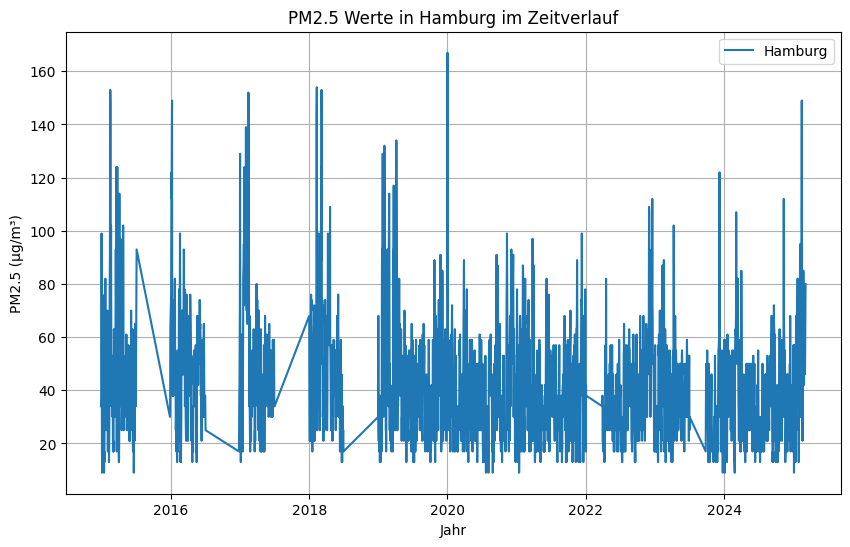

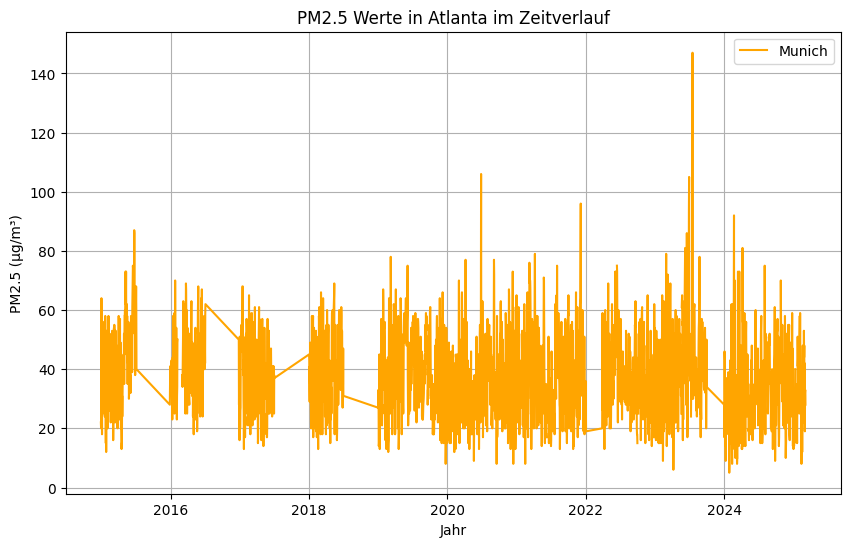

In [13]:
# Plot der Zeitreihe für Hamburg
plt.figure(figsize=(10, 6))
plt.plot(df_hamburg.index, df_hamburg['Pm25'], label='Hamburg')
plt.title('PM2.5 Werte in Hamburg im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.legend();

# Plot der Zeitreihe für Atlanta
plt.figure(figsize=(10, 6))
plt.plot(df_atlanta.index, df_atlanta['Pm25'], label='Munich', color='orange')
plt.title('PM2.5 Werte in Atlanta im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.legend();


Es fällt unmittelbar auf, dass beide Städte für dieselben Zeiträume Lücken aufweisen. Dies lässt systematische Lücken in den Inputdaten vermuten.

Da die Messwerte stark schwanken, schauen wir uns zusätzlich den gleitenden Durchschnitt (moving average, rolling average) an, der helfen kann, kurzfristige Fluktuationen auszugleichen und dadurch langfristige Trends besser sichtbar zu machen.

In [14]:
# Gleitender Durchschnitt (z. B. über 12 Monate)
df_hamburg['PM25_MA'] = df_hamburg['Pm25'].rolling(window=12).mean()
df_atlanta['PM25_MA'] = df_atlanta['Pm25'].rolling(window=12).mean()

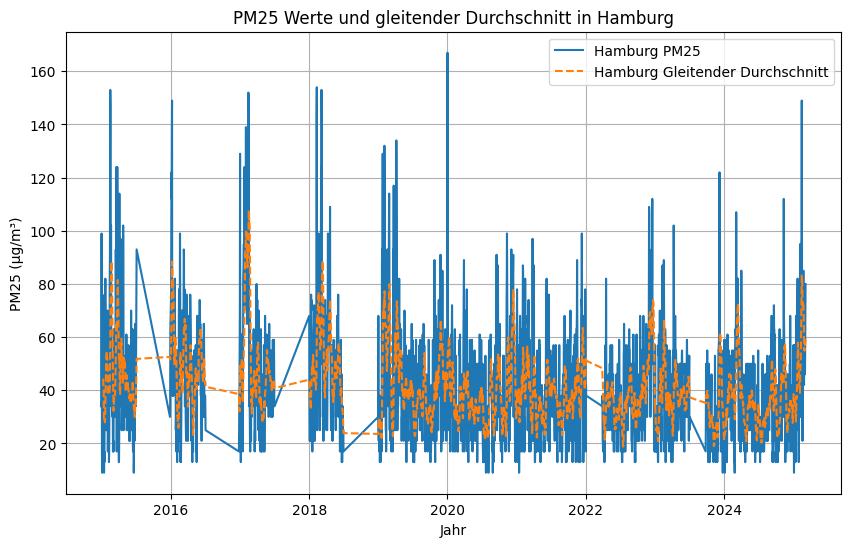

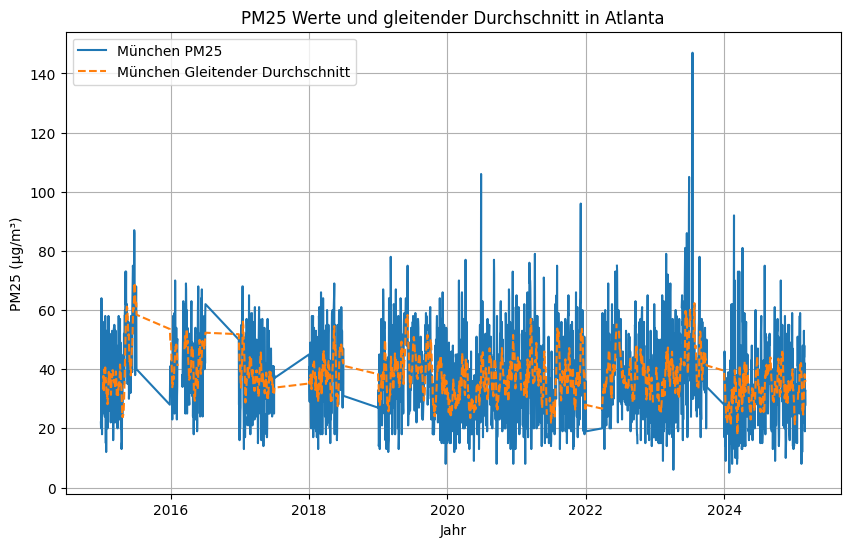

In [16]:
import matplotlib.dates as mdates


# Plot mit gleitendem Durchschnitt
plt.figure(figsize=(10, 6))
plt.plot(df_hamburg.index, df_hamburg['Pm25'], label='Hamburg PM25')
plt.plot(df_hamburg.index, df_hamburg['PM25_MA'], label='Hamburg Gleitender Durchschnitt', linestyle='--')
plt.title('PM25 Werte und gleitender Durchschnitt in Hamburg')
plt.xlabel('Jahr')
plt.ylabel('PM25 (µg/m³)')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(df_atlanta.index, df_atlanta['Pm25'], label='München PM25')
plt.plot(df_atlanta.index, df_atlanta['PM25_MA'], label='München Gleitender Durchschnitt', linestyle='--')
plt.title('PM25 Werte und gleitender Durchschnitt in Atlanta')
plt.xlabel('Jahr')
plt.ylabel('PM25 (µg/m³)')
plt.legend()
plt.grid(True)

Insgesamt gesehen zeigen sich in beiden Städten kaum Veränderungen über die Zeit. Es kann aber trotzdem zum Beispiel saisonale Schawankungen geben, die mit der bisherigen Darstellungsweise nicht sichtbar werden.

Wir grupperien also alle Messwerte nach Monaten und berechnen den Durchschnitt (mean):

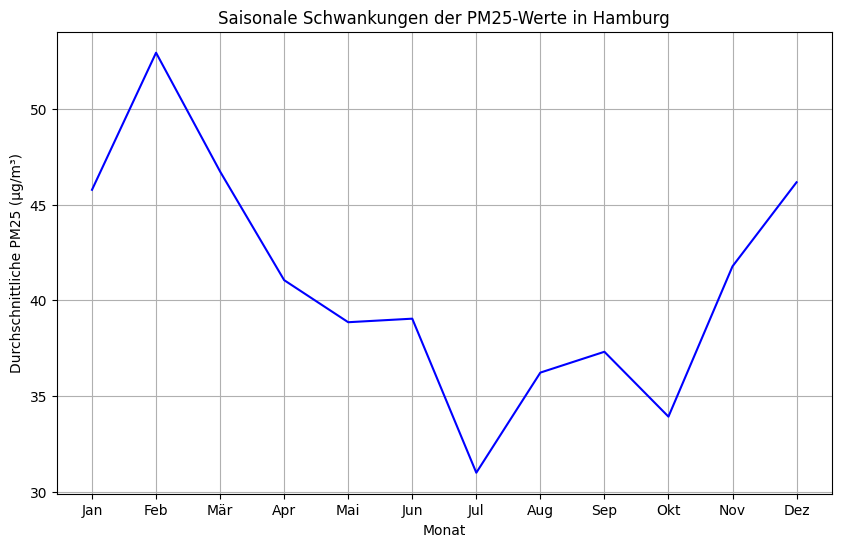

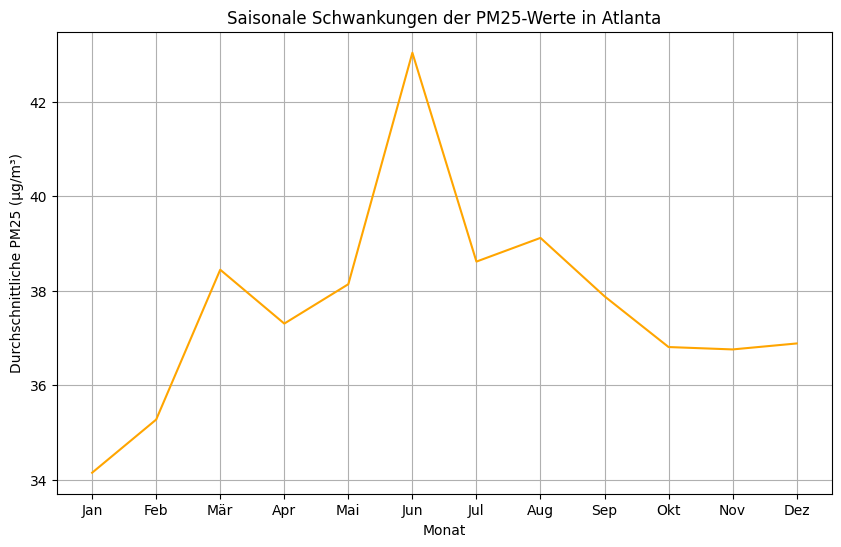

In [17]:
# Gruppiere die Daten nach Monat und berechne den Durchschnitt
df_hamburg_monthly = df_hamburg.groupby(df_hamburg.index.month)['Pm25'].mean()
df_atlanta_monthly = df_atlanta.groupby(df_atlanta.index.month)['Pm25'].mean()

# Plots für saisonale Schwankungen
plt.figure(figsize=(10, 6))
plt.plot(df_hamburg_monthly.index, df_hamburg_monthly, label='Hamburg', color='blue')
plt.title('Saisonale Schwankungen der PM25-Werte in Hamburg')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche PM25 (µg/m³)')
plt.grid(True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']);

plt.figure(figsize=(10, 6))
plt.plot(df_atlanta_monthly.index, df_atlanta_monthly, label='Atlanta', color='orange')
plt.title('Saisonale Schwankungen der PM25-Werte in Atlanta')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche PM25 (µg/m³)')
plt.grid(True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']);


Hamburg und Atlanta zeigen gegenläufige saisonale Muster. Mögliche Begründung:

- In Hamburg könnte die kühlere Luft und die stärkere Regen- und Windaktivität im Sommer für niedrigere PM2.5-Werte sorgen.

- In Atlanta könnte das heiße, feuchte Klima im Sommer zusammen mit weniger Luftzirkulation und mehr Verkehr und Industrieaktivitäten die PM2.5-Werte ansteigen lassen.

Diese und ansere Hypothesen können in einer zusätzlichen Analyse geprüft werden, in der die ebenfalls vorhandenen Wetterdaten genutzt werden.

In eine Darstellung der saisonalen Veränderungen kann auch die Streuung der Werte mit einbezogen werden, um ein vollständigeres Gesamtbild zu erhalten. Diese kann entweder mit dem Mittelwert (mean) oder dem Interquartilsabstand (IQR) berechnet werden. Der hier gewählte IQR ist in der Berechnung aufwändiger, aber unempfindlicher gegenüber Ausreißern:

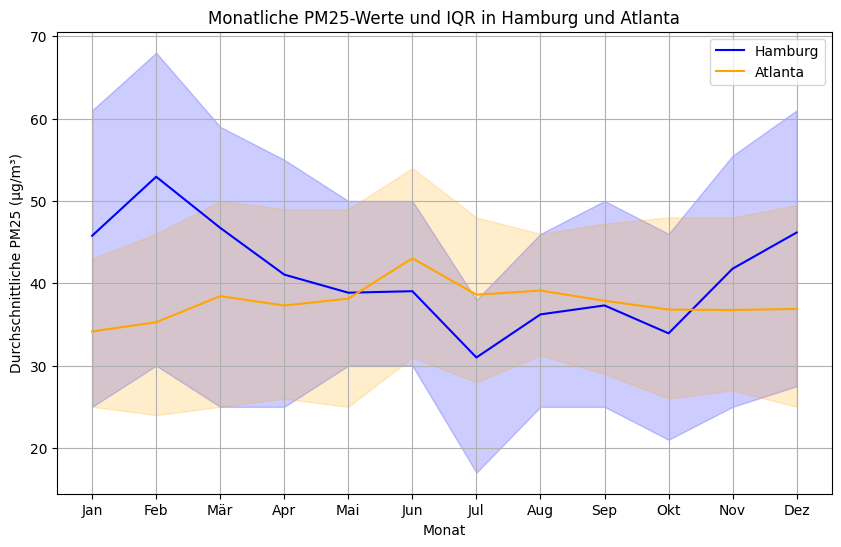

In [18]:
# Berechnung des monatlichen Mittelwerts und des Interquartilbereichs (IQR)
df_hamburg_monthly_iqr = df_hamburg.groupby(df_hamburg.index.month)['Pm25'].agg(lambda x: x.quantile(0.75) - x.quantile(0.25))
df_atlanta_monthly_iqr = df_atlanta.groupby(df_atlanta.index.month)['Pm25'].agg(lambda x: x.quantile(0.75) - x.quantile(0.25))

# Berechnung des 25. und 75. Perzentils
df_hamburg_monthly = df_hamburg.groupby(df_hamburg.index.month)['Pm25'].agg(['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
df_atlanta_monthly = df_atlanta.groupby(df_atlanta.index.month)['Pm25'].agg(['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])

# Plot der monatlichen Mittelwerte und IQR als Fläche
plt.figure(figsize=(10, 6))

# Hamburg
plt.plot(df_hamburg_monthly.index, df_hamburg_monthly['mean'], label='Hamburg', color='blue')
plt.fill_between(df_hamburg_monthly.index, 
                 df_hamburg_monthly['<lambda_0>'], 
                 df_hamburg_monthly['<lambda_1>'], 
                 color='blue', alpha=0.2)

# Atlanta
plt.plot(df_atlanta_monthly.index, df_atlanta_monthly['mean'], label='Atlanta', color='orange')
plt.fill_between(df_atlanta_monthly.index, 
                 df_atlanta_monthly['<lambda_0>'], 
                 df_atlanta_monthly['<lambda_1>'], 
                 color='orange', alpha=0.2)

# Formatierung und Beschriftungen
plt.title('Monatliche PM25-Werte und IQR in Hamburg und Atlanta')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche PM25 (µg/m³)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])
plt.legend()
plt.grid(True);


An hohen Varianz der Werte sehen wir vor allem eines deutlich: Die PM2.5-Werte sind sehr volatil, was das Bestimmen von Trends mit den bisher gezeigten Mitteln schwer macht.

Um die lnggfristigen Trends sichtbar zu machen, wird als nächstes eine Zeitreihenzerlegung durchgeführt. Dabei wird deine Zeitreihe in drei Komponenten aufgeteilt: den Trend (langfristige Entwicklung), die Saisonkomponente (regelmäßige Schwankungen, z. B. saisonal) und die Residuen (das Rauschen, was nach Entfernung von Trend und Saison übrigbleibt).

Wir verwenden dazu eine gängige Methode aus dem Paket `statsmodels`, und zwar die Funktion `seasonal_decompose`.

# 3. Zeitreihenzerlegung: Hamburg

Wir verwenden die Jahre 2015-2024. Die Daten davor und danach müssen also vorab entfernt werden.

Da wir fehlende Daten haben, müssen wir entscheiden, wie wir mit ihnen umgehen. Im Folgenden werden zwei Möglichkeiten gezeigt:

- `dropna()`: Alle NaN-Werte werden vorab entfernt.
- `interploate()`: Die NaN-Werte werden durch benachbarte Datenpunkte ersetzt

Bei der Modellierung verfolgen wir einen additiven Ansatz (`model='additive'`), da wir davon ausgehen, dass die saisonalen Schwankungen in den Daten relativ konstant sind und nicht mit einem Anstieg oder Abfall der Gesamtwerte skalieren.

Da wir die Zeitreihe auf der Ebene von Monaten ansetzen, verwenden wir `period=12`. Damit berechnen wir für jeden Monat im Jahr einen Wert. `period=12` teilt also die Zeitreihe in 12 Abschnitte pro Zyklus. Für jeden dieser Abschnitte wird ein saisonaler Wert ermittelt, der dann als wiederkehrender Effekt in jedem Jahr erscheint.

Enthaltene Jahre: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_18475/3957627563.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_hamburg_monthly = df_hamburg_filtered['Pm25'].resample('M').mean().dropna()


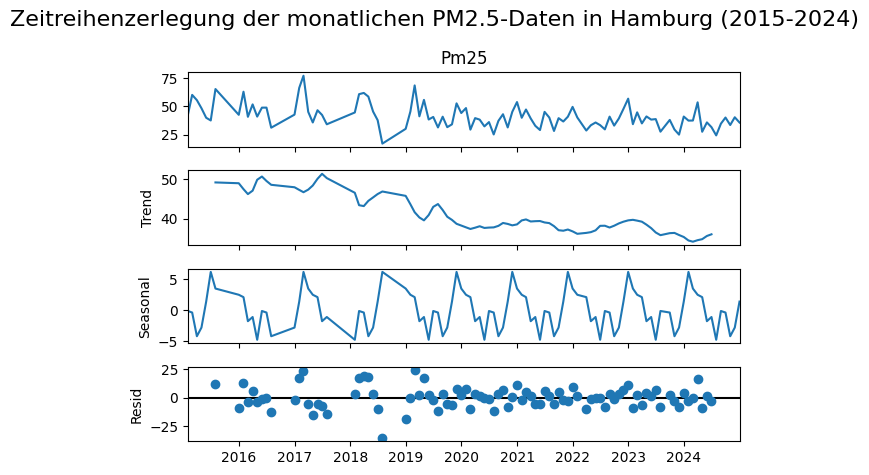

In [22]:
# Filtern: Nur Daten von 2015 bis 2024 behalten
df_hamburg_filtered = df_hamburg[(df_hamburg.index.year >= 2015) & (df_hamburg.index.year <= 2024)]

# Überprüfen, welche Jahre jetzt enthalten sind
print("Enthaltene Jahre:", sorted(df_hamburg_filtered.index.year.unique()))

# Aggregiere die PM2.5-Daten auf monatlicher Basis (mittlere Werte)
df_hamburg_monthly = df_hamburg_filtered['Pm25'].resample('M').mean().dropna()

# Zeitreihenzerlegung (additives Modell mit period=12 für monatliche Daten
result = seasonal_decompose(df_hamburg_monthly, model='additive', period=12)

# Visualisierung der Zerlegung
result.plot()

plt.suptitle('Zeitreihenzerlegung der monatlichen PM2.5-Daten in Hamburg (2015-2024)', fontsize=16)
plt.tight_layout();

plt.savefig("./images/Zeitreihenzerlegung_Hamburg.png", dpi=300, bbox_inches="tight")

Die vier Graphen der Zeitreihenzerlegung für Hamburg zeigen:

1. starke Schwankungnen des PM2.5-Werts über die Jahre hinweg; stärker ausgeprägt vor 2019 (hier gibt es einige mehrmonatige Abschnitte ohne Daten!)
2. einen langfristig eindeutig fallenden Trend
3. deutliche saisonale Muster: höchste Belastung im Winter
3. gleichmäßig um die Nulllinie verteilte Residuen, d.h. das Modell ist im Durchschnitt gut ausbalanciert ist und nimmt keine systematische Überschätzung oder Unterschätzung vor

Wir sehen an allen Graphen, dass fehlende Werte, v.a. wenn sie Blockweise vorkommen, ein zeitreihenmodell erwartungsgemäß erheblich stören. Das Problem kann durch Interpolation abgemildert werden, aber Verzerrungen bleiben dennoch erhalten.

# Zeitreihenzerlegung: Atlanta

Das für Hamburg erläuterte Vorgehen wird nun für Atlanta wiederholt.

Enthaltene Jahre: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_18475/1726028714.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_atlanta_monthly = df_atlanta_filtered['Pm25'].resample('M').mean().dropna()


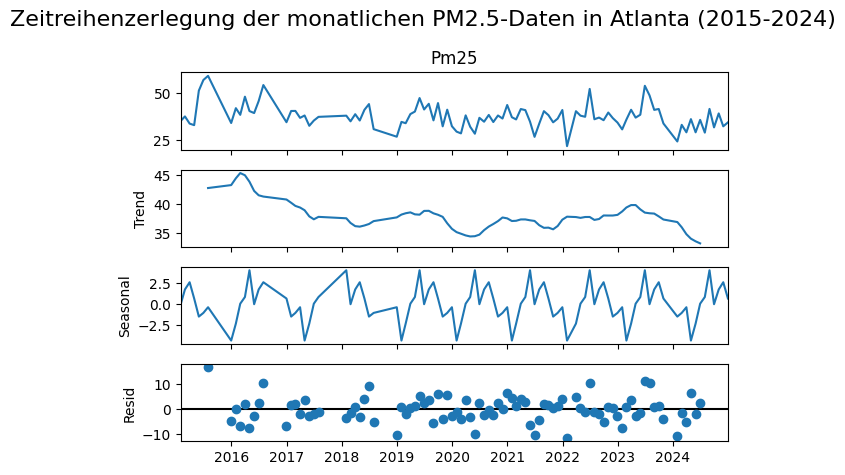

In [24]:
# Filtern: Nur Daten von 2015 bis 2024 behalten
df_atlanta_filtered = df_atlanta[(df_atlanta.index.year >= 2015) & (df_atlanta.index.year <= 2024)]

# Überprüfen, welche Jahre jetzt enthalten sind
print("Enthaltene Jahre:", sorted(df_atlanta_filtered.index.year.unique()))

# Aggregiere die PM2.5-Daten auf monatlicher Basis (mittlere Werte)
df_atlanta_monthly = df_atlanta_filtered['Pm25'].resample('M').mean().dropna()

# Zeitreihenzerlegung (additives Modell mit period=12, da es monatliche Daten sind)
result = seasonal_decompose(df_atlanta_monthly, model='additive', period=12)

# Visualisierung der Zerlegung
result.plot()

plt.suptitle('Zeitreihenzerlegung der monatlichen PM2.5-Daten in Atlanta (2015-2024)', fontsize=16)
plt.tight_layout();

plt.savefig("./images/Zeitreihenzerlegung_Atlanta.png", dpi=300, bbox_inches="tight")

Die vier Graphen der Zeitreihenzerlegung für Atlanta zeigen:

1. deutliche Schwankungnen des PM2.5-Werts über die Jahre hinweg
2. einen klar fallenden Trend für den Zeitraum 2016-2019, danach einen leichten Anstieg auf ein gleichbleibendes Niveau von 35-40 µg/m³. Deutlicher Abfall zum Ende des erfassten Zeitraums.
3. deutliche saisonale Muster: höchste Belastung im Sommer
3. gleichmäßig um die Nulllinie verteilte Residuen, d.h. das Modell ist im Durchschnitt gut ausbalanciert ist und nimmt keine systematische Überschätzung oder Unterschätzung vor.

# 5. Zusammenfassende Bewertung

**Datenqualität**:
Für eine realitätsnahe Zeitreihenanalyse ist eine durchgängige Datengrundlage unabdingbar. Während einzelne, kleine Datenlücken durch Interpolation ausgeglichen werden können, führen mehrmonatige Lücken zu erheblichen Verzerrungen, die kein Modell vollständig kompensieren kann.

**Einfache Analysen und Visualisierungen**:
Ansätze mit Pandas und Matplotlib liefern erste, wertvolle Hinweise auf Trends und saisonale Muster. Allerdings werden diese Methoden schnell unübersichtlich, wenn die Zielwerte stark volatil sind – die resultierenden Grafiken schwanken dann oft so stark, dass eindeutige Muster schwer erkennbar sind.

**Zeitreihenzerlegung**:
Die Anwendung einer Zeitreihenzerlegung (z. B. mittels STL oder seasonal_decompose) kann helfen, trotz hoher Volatilität langfristige Trends und wiederkehrende saisonale Muster sichtbar zu machen. Dennoch ist auch hier die Vollständigkeit und Zuverlässigkeit der Daten entscheidend für die Qualität und Aussagekraft der Ergebnisse.

Insgesamt zeigt die Analyse, dass eine fundierte Zeitreihenanalyse nicht nur auf geeignete Methoden, sondern vor allem auf hochwertige und lückenfreie Daten angewiesen ist.